In [2]:
import pandas as pd 
import numpy as np
import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
#These are modules for audio processing
import librosa
import librosa.display  #audio visualization

In [4]:

audio_file_path="Urban Sound/fold1/101415-3-0-3.wav"
audio_data,sample_rate = librosa.load(audio_file_path)
     

In [5]:
print(audio_data)

[-0.00058609 -0.00104031 -0.00083608 ... -0.00025773 -0.00023362
 -0.00033846]


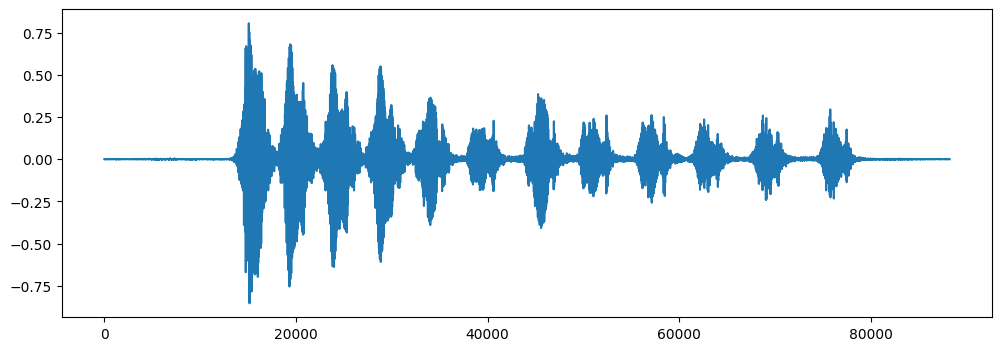

In [6]:
plt.figure(figsize=(12,4))
plt.plot(audio_data)

In [7]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [8]:
import pandas as pd
import os

audio_dataset_path='Urban Sound'
metadata=pd.read_csv('Urban Sound/UrbanSound8K.csv')
metadata.head()
label=metadata['class']

In [9]:
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

In [10]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [11]:
import numpy as np
from tqdm import tqdm

# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients

extracted_features=[]

for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

8732it [11:28, 12.68it/s]


In [12]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.52066, 52.00812, -...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [13]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
     

In [14]:
X.shape, y.shape

((8732, 40), (8732,))

In [15]:
y=np.array(pd.get_dummies(y))

In [16]:
y.shape

(8732, 10)

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [37]:
def data_summary(X_train, y_train, X_test, y_test):
    """Summarize current state of dataset"""
    print('Train images shape:', X_train.shape)
    print('Train labels shape:', y_train.shape)
    print('Test images shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)
data_summary(X_train,y_train,X_test,y_test)

Train images shape: (6112, 40)
Train labels shape: (6112, 10)
Test images shape: (2620, 40)
Test labels shape: (2620, 10)


In [38]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.optimizers import Adam
from sklearn import metrics

In [39]:
num_labels=y.shape[1]
num_labels

10

In [40]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               4100      
                                                                 
 activation_4 (Activation)   (None, 100)               0         
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               20200     
                                                                 
 activation_5 (Activation)   (None, 200)               0         
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [42]:

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],optimizer='adam')

In [43]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
120/123 [============================>.] - ETA: 0s - loss: 11.7693 - accuracy: 0.1228
Epoch 1: val_loss improved from inf to 2.27941, saving model to saved_models\audio_classification.hdf5
123/123 [==============================] - 2s 9ms/step - loss: 11.6144 - accuracy: 0.1227 - val_loss: 2.2794 - val_accuracy: 0.0989
Epoch 2/100
114/123 [==========================>...] - ETA: 0s - loss: 2.7974 - accuracy: 0.1298
Epoch 2: val_loss improved from 2.27941 to 2.27869, saving model to saved_models\audio_classification.hdf5
123/123 [==============================] - 1s 6ms/step - loss: 2.7764 - accuracy: 0.1291 - val_loss: 2.2787 - val_accuracy: 0.1191
Epoch 3/100
122/123 [============================>.] - ETA: 0s - loss: 2.4100 - accuracy: 0.1338
Epoch 3: val_loss improved from 2.27869 to 2.26817, saving model to saved_models\audio_classification.hdf5
123/123 [==============================] - 1s 7ms/step - loss: 2.4102 - accuracy: 0.1340 - val_loss: 2.2682 - val_accuracy: 0.13

In [44]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])
print(test_accuracy[1])

0.7891033887863159
0.7561068534851074


In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

prediction_feature=model.predict(X_test)
cm = confusion_matrix(y_test, prediction_feature)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

82/82 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [46]:
X_test[1]

array([-466.17957   ,    1.0950246 ,  -34.01389   ,   35.33935   ,
        -14.88148   ,  -19.12843   ,   -0.581684  ,  -16.130579  ,
        -21.339075  ,    7.673634  ,  -29.16449   ,  -18.950253  ,
         -2.9579992 ,   -8.16233   ,  -15.153101  ,   -6.604805  ,
         -7.5685983 ,    9.340646  ,   14.4331    ,   21.934181  ,
         20.861397  ,    1.3340122 ,  -19.228804  ,   -4.630231  ,
         -1.0564744 ,    3.215267  ,   -6.984281  ,  -16.414577  ,
        -10.0286455 ,   13.009954  ,    0.53346086,  -23.843391  ,
        -15.267321  ,    9.245734  ,   10.367627  ,   -0.583201  ,
         -1.2624055 ,   17.700016  ,   13.847463  ,   -5.1862826 ],
      dtype=float32)

In [47]:
prediction_feature.shape

(2620, 10)

In [48]:
print("Classes are -\n",metadata['class'].unique())


Classes are -
 ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


In [51]:
from sklearn.preprocessing import LabelEncoder
filename="Urban Sound/fold6/194321-9-0-126.wav"
audio, sample_rate = librosa.load(filename) 
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
le = LabelEncoder()
le.fit(label)
mfccs_mean = np.mean(mfccs.T,axis=0).reshape(1,-1)
#print(model.input_shape)
#print(mfccs_mean)
mfccs_scaled_features = mfccs_mean

#print(mfccs_scaled_features)
#print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
print(predicted_label)
classes_x=np.argmax(predicted_label,axis=1)
prediction_class = le.inverse_transform(classes_x)
print("The predicted class label is ",prediction_class)


1/1 [==============================] - 0s 29ms/step
[[0.00278159 0.10838973 0.07590482 0.10030219 0.14134133 0.00406198
  0.01619629 0.00460706 0.0059403  0.5404748 ]]
The predicted class label is  ['street_music']
